In [1]:
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten,BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from random import seed
from random import randint


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report as cr

In [3]:
seed = 16
filename = '../Datos/fer2013.csv'
label_map = ['Enfado', 'Asco', 'Miedo', 'Alegria', 'Tristeza', 'Sorpresa', 'Neutral']
label_map = np.array(label_map)
names=['emocion','pixels','uso']
df=pd.read_csv(filename,names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emocion,pixels,uso
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [4]:
def loadData(filname):
    
    Y_train = []
    X_train = []
    Y_test = []
    X_test = []
    
    first = True
    uso = 'Training\n'
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            condition = str(row[2])
            if condition == 'Training\n':
                Y_train.append(int(row[0]))
                X_train.append([int(p) for p in row[1].split()])
            else:
                Y_test.append(int(row[0]))
                X_test.append([int(p) for p in row[1].split()])
                
    X_train, Y_train = np.array(X_train)/255.0 , np.array(Y_train)
    X_test, Y_test = np.array(X_test)/255.0 , np.array(Y_test)

    return X_train, X_test, Y_train, Y_test 

In [5]:
X_train, X_test, Y_train, Y_test= loadData(filename)

In [6]:
N_train = X_train.shape[0]
N_test = X_test.shape[0]
X_train = X_train.reshape(N_train, 48, 48,1)
X_test = X_test.reshape(N_test, 48, 48,1)

In [7]:
# one hot encode output
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
class_num = Y_test.shape[1]

In [8]:
model = Sequential()

model.add(Conv2D(6,(5,5),input_shape=X_train.shape[1:],padding = 'valid', strides = 1, activation = 'tanh'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(16,(5,5),input_shape=X_train.shape[1:],padding = 'valid', strides = 1, activation = 'tanh'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='tanh',kernel_constraint=maxnorm(3)))
model.add(Dense(84, activation='tanh',kernel_constraint=maxnorm(3)))
model.add(Dense(class_num, activation='softmax',kernel_constraint=maxnorm(3)))

In [9]:
model.summary()
optimizer = 'adam'
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 44, 44, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 22, 22, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 9, 9, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1296)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               166016    
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [10]:
epochs = 100

es = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mc = ModelCheckpoint('.ln5_1.hdf5', save_best_only=True, monitor='val_loss', mode='min')
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')

np.random.seed(16)
cb =  [es,mc,rlr]
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, callbacks = cb)

Epoch 1/100
449/449 [==============================] - 49s 109ms/step - loss: 1.6821 - accuracy: 0.3394 - val_loss: 1.6268 - val_accuracy: 0.3697 - lr: 0.0010
Epoch 2/100
449/449 [==============================] - 43s 95ms/step - loss: 1.6252 - accuracy: 0.3672 - val_loss: 1.6153 - val_accuracy: 0.3650 - lr: 0.0010
Epoch 3/100
449/449 [==============================] - 37s 83ms/step - loss: 1.5910 - accuracy: 0.3782 - val_loss: 1.5886 - val_accuracy: 0.3798 - lr: 0.0010
Epoch 4/100
449/449 [==============================] - 39s 87ms/step - loss: 1.5548 - accuracy: 0.3980 - val_loss: 1.5483 - val_accuracy: 0.3958 - lr: 0.0010
Epoch 5/100
449/449 [==============================] - 39s 88ms/step - loss: 1.5072 - accuracy: 0.4164 - val_loss: 1.5236 - val_accuracy: 0.4089 - lr: 0.0010
Epoch 6/100
449/449 [==============================] - 40s 90ms/step - loss: 1.4499 - accuracy: 0.4403 - val_loss: 1.4909 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 7/100
449/449 [==============================

In [11]:
model.load_weights('.ln5_1.hdf5')
pred = np.array(model.predict(X_test))
pred = np.around(pred)
pred = pred.astype(int)
Y_test = Y_test.astype(int)




In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    fig, ax = plt.subplots(figsize = (5,5))
  
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_ylim(-0.5, 6.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix
[[ 797    0    4  102    5   10   40]
 [  97    0    0    6    1    0    7]
 [ 790    0   34   75    9   61   55]
 [ 836    0    6  903    0   12   17]
 [1042    0    4   95   29   12   65]
 [ 436    0    3   29    2  344   17]
 [ 877    0    1  105    6   14  230]]


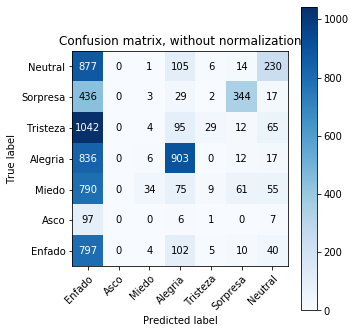

In [13]:
plot_confusion_matrix(Y_test.argmax(axis=1),pred.argmax(axis=1),label_map)

In [14]:
print(cr(Y_test.argmax(axis=1),pred.argmax(axis=1),target_names = label_map))


              precision    recall  f1-score   support

      Enfado       0.16      0.83      0.27       958
        Asco       0.00      0.00      0.00       111
       Miedo       0.65      0.03      0.06      1024
     Alegria       0.69      0.51      0.58      1774
    Tristeza       0.56      0.02      0.04      1247
    Sorpresa       0.76      0.41      0.54       831
     Neutral       0.53      0.19      0.28      1233

    accuracy                           0.33      7178
   macro avg       0.48      0.29      0.25      7178
weighted avg       0.56      0.33      0.31      7178



C:\Users\mateo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
model = Sequential()

model.add(Conv2D(6,(5,5),input_shape=X_train.shape[1:],padding = 'valid', strides = 1, activation = 'relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(16,(5,5),input_shape=X_train.shape[1:],padding = 'valid', strides = 1, activation = 'relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_constraint=maxnorm(3)))
model.add(Dense(84, activation='relu',kernel_constraint=maxnorm(3)))
model.add(Dense(class_num, activation='softmax',kernel_constraint=maxnorm(3)))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 44, 44, 6)         156       
_________________________________________________________________
average_pooling2d_2 (Average (None, 22, 22, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 16)        2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 9, 9, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1296)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               166016    
_________________________________________________________________
dense_4 (Dense)              (None, 84)               

In [16]:


mc = ModelCheckpoint('.ln5_2.hdf5', save_best_only=True, monitor='val_loss', mode='min')
cb =  [es,mc,rlr]

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, callbacks = cb)


Epoch 1/100
449/449 [==============================] - 38s 85ms/step - loss: 1.6586 - accuracy: 0.3422 - val_loss: 1.5666 - val_accuracy: 0.3801 - lr: 0.0010
Epoch 2/100
449/449 [==============================] - 37s 83ms/step - loss: 1.5223 - accuracy: 0.4146 - val_loss: 1.4856 - val_accuracy: 0.4225 - lr: 0.0010
Epoch 3/100
449/449 [==============================] - 39s 87ms/step - loss: 1.4448 - accuracy: 0.4405 - val_loss: 1.4387 - val_accuracy: 0.4400 - lr: 0.0010
Epoch 4/100
449/449 [==============================] - 40s 88ms/step - loss: 1.3774 - accuracy: 0.4678 - val_loss: 1.3840 - val_accuracy: 0.4746 - lr: 0.0010
Epoch 5/100
449/449 [==============================] - 42s 93ms/step - loss: 1.3149 - accuracy: 0.4963 - val_loss: 1.3762 - val_accuracy: 0.4784 - lr: 0.0010
Epoch 6/100
449/449 [==============================] - 43s 95ms/step - loss: 1.2578 - accuracy: 0.5206 - val_loss: 1.3512 - val_accuracy: 0.4777 - lr: 0.0010
Epoch 7/100
449/449 [==============================]

Confusion matrix
[[ 776    0   20   69   29   20   44]
 [  94    9    3    4    0    1    0]
 [ 697    0  116   53   67   56   35]
 [ 533    0   12 1152   22   18   37]
 [ 955    0   12   67  140   11   62]
 [ 307    0   34   39   10  424   17]
 [ 754    0   14   87   44    9  325]]
              precision    recall  f1-score   support

      Enfado       0.19      0.81      0.31       958
        Asco       1.00      0.08      0.15       111
       Miedo       0.55      0.11      0.19      1024
     Alegria       0.78      0.65      0.71      1774
    Tristeza       0.45      0.11      0.18      1247
    Sorpresa       0.79      0.51      0.62       831
     Neutral       0.62      0.26      0.37      1233

    accuracy                           0.41      7178
   macro avg       0.63      0.36      0.36      7178
weighted avg       0.59      0.41      0.41      7178



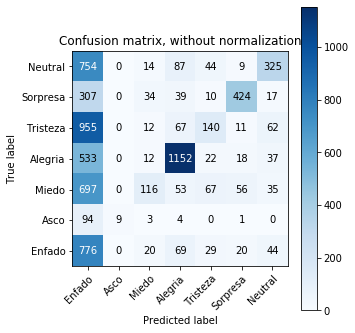

In [17]:
model.load_weights('.ln5_2.hdf5')
pred = np.array(model.predict(X_test))
pred = np.around(pred)
pred = pred.astype(int)
Y_test = Y_test.astype(int)


plot_confusion_matrix(Y_test.argmax(axis=1),pred.argmax(axis=1),label_map)
print(cr(Y_test.argmax(axis=1),pred.argmax(axis=1),target_names = label_map))

In [18]:
model = Sequential()

model.add(Conv2D(6,(5,5),input_shape=X_train.shape[1:],padding = 'valid', strides = 1, activation = 'relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16,(5,5),input_shape=X_train.shape[1:],padding = 'valid', strides = 1, activation = 'relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_constraint=maxnorm(3)))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(84, activation='relu',kernel_constraint=maxnorm(3)))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(class_num, activation='softmax',kernel_constraint=maxnorm(3)))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 44, 44, 6)         156       
_________________________________________________________________
dropout (Dropout)            (None, 44, 44, 6)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 44, 44, 6)         24        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 18, 18, 16)        2416      
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 18, 16)       

In [19]:


mc = ModelCheckpoint('.ln5_3.hdf5', save_best_only=True, monitor='val_loss', mode='min')
cb =  [es,mc,rlr]

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, callbacks = cb)

Epoch 1/100
449/449 [==============================] - 103s 230ms/step - loss: 1.8175 - accuracy: 0.3190 - val_loss: 2.0165 - val_accuracy: 0.2646 - lr: 0.0010
Epoch 2/100
449/449 [==============================] - 103s 229ms/step - loss: 1.5390 - accuracy: 0.4007 - val_loss: 1.5201 - val_accuracy: 0.4014 - lr: 0.0010
Epoch 3/100
449/449 [==============================] - 115s 257ms/step - loss: 1.4543 - accuracy: 0.4380 - val_loss: 1.4721 - val_accuracy: 0.4230 - lr: 0.0010
Epoch 4/100
449/449 [==============================] - 122s 271ms/step - loss: 1.4056 - accuracy: 0.4600 - val_loss: 1.4200 - val_accuracy: 0.4537 - lr: 0.0010
Epoch 5/100
449/449 [==============================] - 107s 238ms/step - loss: 1.3564 - accuracy: 0.4797 - val_loss: 1.4573 - val_accuracy: 0.4413 - lr: 0.0010
Epoch 6/100
449/449 [==============================] - 103s 229ms/step - loss: 1.3191 - accuracy: 0.4933 - val_loss: 1.4179 - val_accuracy: 0.4578 - lr: 0.0010
Epoch 7/100
449/449 [===================

Confusion matrix
[[ 763    1   10   57   81    7   39]
 [  79   22    0    6    3    1    0]
 [ 688    1   83   30  127   59   36]
 [ 459    0    5 1205   63   15   27]
 [ 765    0   11   63  332    6   70]
 [ 306    0   13   38   10  448   16]
 [ 685    1    3   79   96    6  363]]
              precision    recall  f1-score   support

      Enfado       0.20      0.80      0.32       958
        Asco       0.88      0.20      0.32       111
       Miedo       0.66      0.08      0.14      1024
     Alegria       0.82      0.68      0.74      1774
    Tristeza       0.47      0.27      0.34      1247
    Sorpresa       0.83      0.54      0.65       831
     Neutral       0.66      0.29      0.41      1233

    accuracy                           0.45      7178
   macro avg       0.64      0.41      0.42      7178
weighted avg       0.63      0.45      0.46      7178



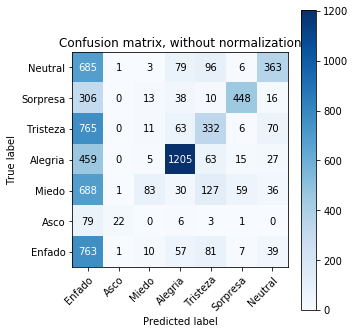

In [20]:
model.load_weights('.ln5_3.hdf5')
pred = np.array(model.predict(X_test))
pred = np.around(pred)
pred = pred.astype(int)
Y_test = Y_test.astype(int)


plot_confusion_matrix(Y_test.argmax(axis=1),pred.argmax(axis=1),label_map)
print(cr(Y_test.argmax(axis=1),pred.argmax(axis=1),target_names = label_map))

In [22]:
X_train, X_test, Y_train, Y_test= loadData(filename)
X_train = X_train.reshape(N_train, 48, 48)

In [23]:
def mirror(img):
    copy = img.copy()
    indx = range(copy.shape[1]-1, -1, -1)
    copy = np.flip(copy, axis = 1)
    return copy


def random_erasing(img):
    copy = img.copy()
    numero_parches=(randint(1,3))
    for i in range(numero_parches):
        tam_h = randint(5,15)
        tam_v = randint(5,15)   
        start_h = randint(0,copy.shape[1]-tam_h)
        start_v = randint(0,copy.shape[0]-tam_v) 
        for i in range(tam_v):
            for j in range(tam_h):
                copy[start_v+i, start_h+j] = 1
    return copy


def tras_x(img, tras):
    order = []
    for i in range(tras):
        order = order + [0]
    order = order + list(range(img.shape[1]- tras))
    copy = img[:,order]
    return copy


def tras_y(img, tras):
    order = []
    for i in range(tras):
        order = order + [0]
    order = order + list(range(img.shape[0]- tras))
    copy = img[order,:]
    return copy

In [24]:
nuevo = []
etiquetas = []


for i in range(N_train):
    
    if np.random.random() < 0.5:
        n = mirror(X_train[i])
        nuevo += [n]
        etiquetas += [Y_train[i]]
        
    if np.random.random() < 0.5:
        if np.random.random() < 0.5:
            n = tras_x(X_train[i],randint(5,15))
        else:
            n = tras_y(X_train[i],randint(5,10))
        nuevo += [n]
        etiquetas += [Y_train[i]]
        
    if np.random.random() < 0.25:
        n = random_erasing(X_train[i])
        nuevo += [n]
        etiquetas += [Y_train[i]]
        

    
    
if len(etiquetas) > 0: 
    nuevo = np.array(nuevo)
    etiquetas =  np.array(etiquetas)
    X_train= np.append(X_train,nuevo,axis=0)
    Y_train = np.append(Y_train, etiquetas)

In [25]:
N_train = X_train.shape[0]
N_test = X_test.shape[0]
X_train = X_train.reshape(N_train, 48, 48,1)
X_test = X_test.reshape(N_test, 48, 48,1)
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
class_num = Y_test.shape[1]

In [26]:
model = Sequential()

model.add(Conv2D(6,(5,5),input_shape=X_train.shape[1:],padding = 'valid', strides = 1, activation = 'relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16,(5,5),input_shape=X_train.shape[1:],padding = 'valid', strides = 1, activation = 'relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_constraint=maxnorm(3)))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(84, activation='relu',kernel_constraint=maxnorm(3)))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(class_num, activation='softmax',kernel_constraint=maxnorm(3)))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 44, 44, 6)         156       
_________________________________________________________________
dropout_4 (Dropout)          (None, 44, 44, 6)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 44, 44, 6)         24        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 6)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 18, 16)        2416      
_________________________________________________________________
dropout_5 (Dropout)          (None, 18, 18, 16)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 18, 18, 16)       

In [27]:
mc = ModelCheckpoint('.ln5_dau.hdf5', save_best_only=True, monitor='val_loss', mode='min')

cb =  [es,mc,rlr]
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, callbacks = cb)

Epoch 1/100
1009/1009 [==============================] - 265s 262ms/step - loss: 1.8153 - accuracy: 0.2935 - val_loss: 1.6227 - val_accuracy: 0.3678 - lr: 0.0010
Epoch 2/100
1009/1009 [==============================] - 247s 245ms/step - loss: 1.5850 - accuracy: 0.3749 - val_loss: 1.4861 - val_accuracy: 0.4246 - lr: 0.0010
Epoch 3/100
1009/1009 [==============================] - 245s 242ms/step - loss: 1.4993 - accuracy: 0.4158 - val_loss: 1.4723 - val_accuracy: 0.4351 - lr: 0.0010
Epoch 4/100
1009/1009 [==============================] - 242s 240ms/step - loss: 1.4332 - accuracy: 0.4444 - val_loss: 1.3295 - val_accuracy: 0.4883 - lr: 0.0010
Epoch 5/100
1009/1009 [==============================] - 239s 236ms/step - loss: 1.3832 - accuracy: 0.4682 - val_loss: 1.3008 - val_accuracy: 0.5007 - lr: 0.0010
Epoch 6/100
1009/1009 [==============================] - 239s 236ms/step - loss: 1.3422 - accuracy: 0.4849 - val_loss: 1.2571 - val_accuracy: 0.5137 - lr: 0.0010
Epoch 7/100
1009/1009 [=====

Confusion matrix
[[ 780    3   11   57   49   11   47]
 [  73   22    0    5    5    1    5]
 [ 635    2  123   41   97   71   55]
 [ 339    0    4 1334   25   23   49]
 [ 779    1   21   59  275    6  106]
 [ 230    0   23   44    9  509   16]
 [ 594    0    6   78   40    3  512]]
              precision    recall  f1-score   support

      Enfado       0.23      0.81      0.36       958
        Asco       0.79      0.20      0.32       111
       Miedo       0.65      0.12      0.20      1024
     Alegria       0.82      0.75      0.79      1774
    Tristeza       0.55      0.22      0.31      1247
    Sorpresa       0.82      0.61      0.70       831
     Neutral       0.65      0.42      0.51      1233

    accuracy                           0.50      7178
   macro avg       0.64      0.45      0.45      7178
weighted avg       0.64      0.50      0.50      7178



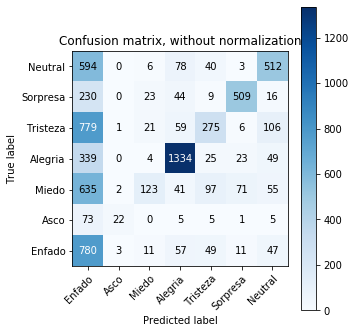

In [28]:
model.load_weights('.ln5_dau.hdf5')
pred = np.array(model.predict(X_test))
pred = np.around(pred)
pred = pred.astype(int)
Y_test = Y_test.astype(int)



plot_confusion_matrix(Y_test.argmax(axis=1),pred.argmax(axis=1),label_map)
print(cr(Y_test.argmax(axis=1),pred.argmax(axis=1),target_names = label_map))